In [ ]:
!pip install translate-toolkit transformers sentencepiece


In [ ]:
!wget -O dataset.txt.zip https://opus.nlpl.eu/download.php?f=TEP/v1/moses/en-fa.txt.zip
!unzip dataset.txt.zip


In [1]:
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:

with open("TEP.en-fa.en", 'rb') as enfile:
  en_lines_list = [line.decode("UTF-8").rstrip() for line in enfile]

with open('TEP.en-fa.fa') as fafile:
  fa_lines_list = [line.rstrip() for line in fafile]

# {"en": "hello", "fa": "سلام"}
sentences = []
for i in range(0, len(en_lines_list)):
  sentences.append({
        "en": en_lines_list[i],
        "fa": fa_lines_list[i]
  })

print("len en lines: ", len(en_lines_list))
print("len fa lines: ", len(fa_lines_list))
print("first en sentence: ", en_lines_list[0])
print("first fa sentence: ", fa_lines_list[0])

len en lines:  612086
len fa lines:  612086
first en sentence:  raspy breathing .
first fa sentence:  صداي خر خر .


In [5]:
sentences[2:8]

[{'en': 'maybe its the wind .', 'fa': 'شايد صداي باد باشه .'},
 {'en': 'no .', 'fa': 'نه .'},
 {'en': 'stop please stop .',
  'fa': 'دست نگه داريد خواهش ميکنم دست نگه داريد .'},
 {'en': 'you have a week , evans then well burn the house .',
  'fa': 'اوانز تو فقط يک هفته وقت داري وگرنه خونتو خواهيم سوزوند .'},
 {'en': 'william .', 'fa': 'ويليام .'},
 {'en': 'god damn it , william .', 'fa': 'لعنتي . ويليام 8 .'}]

In [5]:
random.shuffle(sentences)
train_slice = int(len(sentences) * 0.80)
train_dataset = sentences[:train_slice]
test_dataset = sentences[train_slice:]

In [7]:
drive.mount('/content/gdrive')

MessageError: ignored

# Prepare data for feed to model

In [6]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'fa': '<fa>',
}

In [18]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def format_translation_data(translations, input_lang, target_lang,
                            tokenizer, seq_len=32):

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, LANG_TOKEN_MAPPING)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, LANG_TOKEN_MAPPING)

  return input_token_ids, target_token_ids

def transform_batch(batch, input_lang, target_lang, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch:
    formatted_data = format_translation_data(
        translation_set, input_lang, target_lang, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, input_lang, target_lang, tokenizer, batch_size=32):
  random.shuffle(dataset)
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, input_lang, target_lang, tokenizer)

# Load Tokenizer & Model English to Persian


In [10]:
model_repo_en2fa = 'persiannlp/mt5-small-parsinlu-translation_en_fa'

model_path_en2fa = "/content/gdrive/MyDrive/mt5_translation_en2fa.pt"
max_seq_len = 20
# model.config.maxlength = 40

In [11]:
tokenizer_en2fa = AutoTokenizer.from_pretrained(model_repo_en2fa, use_fast=False)

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/609 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [12]:
# Model description: https://metatext.io/models/persiannlp-mt5-small-parsinlu-translation_en_fa
model_en2fa = AutoModelForSeq2SeqLM.from_pretrained(model_repo_en2fa)
model_en2fa = model_en2fa.cuda()

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [13]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer_en2fa.add_special_tokens(special_tokens_dict)
model_en2fa.resize_token_embeddings(len(tokenizer_en2fa))

Embedding(250102, 512)

In [25]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[9], "en", "fa", tokenizer_en2fa)

print(' '.join(tokenizer_en2fa.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer_en2fa.convert_ids_to_tokens(out_ids)))

<fa> ▁he ▁was ▁italian ▁oh ▁ , ▁fuck ▁you ▁ , ▁ignor amus ▁ . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁اون ▁ ايت الي ايي ▁بود ▁ . ▁لع نتي ▁ . ▁بي ▁س واد ▁ . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [ ]:
model_en2fa.load_state_dict(torch.load(model_path_en2fa))

In [26]:
# Constants
n_epochs = 4
batch_size = 64
print_freq = 50
checkpoint_freq = 1000
lr = 5e-3
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

# Optimizer
optimizer = AdamW(model_en2fa.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [27]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, "en", "fa",
                                      tokenizer_en2fa, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [28]:
losses_en2fa = []

In [32]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, "en", "fa",
                                      tokenizer_en2fa, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model_en2fa.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses_en2fa.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses_en2fa[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model_en2fa, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      if abs(test_loss - avg_loss) < 1:
        torch.save(model_en2fa.state_dict(), model_path_en2fa)

torch.save(model_en2fa.state_dict(), '/content/gdrive/MyDrive/finalen2fa.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/7652 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses_en2fa)-window_size):
  smoothed_losses.append(np.mean(losses_en2fa[i:i+window_size]))

plt.plot(smoothed_losses[100:])

##
# Load Tokenizer & Model Persian to English

In [8]:
model_repo_fa2en = 'google/mt5-small'
model_path_fa2en = "/content/gdrive/MyDrive/mt5_translation_fa2en.pt"
max_seq_len = 20

In [9]:
tokenizer_fa2en = AutoTokenizer.from_pretrained(model_repo_fa2en, use_fast=False)

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/553 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [10]:
# Model description: https://huggingface.co/google/mt5-small
model_fa2en = AutoModelForSeq2SeqLM.from_pretrained(model_repo_fa2en)
model_fa2en = model_fa2en.cuda()

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [11]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer_fa2en.add_special_tokens(special_tokens_dict)
model_fa2en.resize_token_embeddings(len(tokenizer_fa2en))

Embedding(250102, 512)

In [12]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[9], "fa", "en", tokenizer_fa2en)

print(' '.join(tokenizer_fa2en.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer_fa2en.convert_ids_to_tokens(out_ids)))

<en> ▁و ▁بعد ▁ بدو ▁ ن ▁خون ريز ي ▁ وارد ▁موج ي نجو ▁ ميش يم </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁then ▁we ▁ could ▁enter ▁muj in ju ▁ without ▁blood shed . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [13]:
model_fa2en.load_state_dict(torch.load(model_path_fa2en))

FileNotFoundError: ignored

In [14]:
# Constants
n_epochs = 4
batch_size = 64
print_freq = 50
checkpoint_freq = 1000
lr = 5e-3
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

# Optimizer
optimizer = AdamW(model_fa2en.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [15]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, "fa", "en",
                                      tokenizer_fa2en, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [16]:
losses_fa2en = []

In [19]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, "fa", "en",
                                      tokenizer_fa2en, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model_fa2en.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses_fa2en.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses_fa2en[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
      
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model_fa2en, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      if abs(test_loss - avg_loss) < 1:
        torch.save(model_fa2en.state_dict(), model_path_fa2en)

torch.save(model_fa2en.state_dict(), '/content/gdrive/MyDrive/final_fa2en.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8608 [00:00<?, ?it/s]

Epoch: 1 | Step: 10 | Avg. loss: 40.675 | lr: 0.00014534883720930232


KeyboardInterrupt: ignored

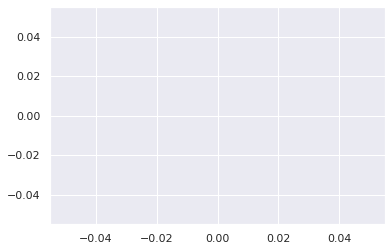

In [20]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses_fa2en)-window_size):
  smoothed_losses.append(np.mean(losses_fa2en[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [23]:
#@title English To Persian Translation
input_text = 'im going to change the subject .' #@param {type:"string"}
output_language = 'fa' #@param ["fa"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer_en2fa,
    seq_len = model_en2fa.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model_en2fa.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer_en2fa.decode(output_tokens[0], skip_special_tokens=True))

NameError: ignored

In [ ]:
#@title Persian To English Translation
input_text = 'من خودم اين کارو انجام ميدهم .' #@param {type:"string"}
output_language = 'en' #@param ["en"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer_fa2en,
    seq_len = model_fa2en.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model_fa2en.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer_fa2en.decode(output_tokens[0], skip_special_tokens=True))